# Listen to some samples

In [1]:
import IPython.display as ipd


ipd.Audio("../input/clean-data/clean_trainset_28spk_wav/p226_001.wav")

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [ ]:
import IPython.display as ipd

ipd.Audio("../input/noisy-data/noisy_trainset_28spk_wav/p226_001.wav")

# Read data

In [40]:
import glob

clean_wavs_path = glob.glob('./data/clear_samples/*.wav')
noisy_wavs_path = glob.glob('./data/noisy_samples/*.wav')

# print the number of samples
print('Number of clean samples: ', len(clean_wavs_path))
print('Number of noisy samples: ', len(noisy_wavs_path))


Number of clean samples:  2570
Number of noisy samples:  2570


In [41]:
class config:
    target_sample_rate=48000
    duration=4
    n_fft=1024
    hop_length=512
    n_mels=64
    batch_size=128
    learning_rate=1e-6
    epochs=6

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchaudio

class CustomDataset(Dataset):
    def __init__(self, clean_data_path, noisy_data_path, transform=None,
                 target_sample_rate=config.target_sample_rate, duration=config.duration):
        self.root_clean = clean_data_path
        self.root_noisy = noisy_data_path
        self.transform = transform
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate*duration
            
    def __len__(self):
        return len(self.root_clean)
    
    def __getitem__(self, index):
        audio_path_clean = self.root_clean[index]
        audio_path_noisy = self.root_noisy[index]
        
        signal, sr = torchaudio.load(audio_path_clean)
        signal_noisy, sr_noisy = torchaudio.load(audio_path_noisy)
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
            signal_noisy = resampler(signal_noisy)
        
        if signal.shape[0] > 1:
            signal = torch.mean(signal, axis=0, keepdim=True)
        
        if signal_noisy.shape[0] > 1:
            signal_noisy = torch.mean(signal_noisy, axis=0, keepdim=True)
        
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
            
        if signal_noisy.shape[1] > self.num_samples:
            signal_noisy = signal_noisy[:, :self.num_samples]
        
        if signal.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal.shape[1]
            signal = F.pad(signal, (0, num_missing_samples))
            
        if signal_noisy.shape[1] < self.num_samples:
            num_missing_samples = self.num_samples - signal_noisy.shape[1]
            signal_noisy = F.pad(signal_noisy, (0, num_missing_samples))
        
        mel = self.transform(signal)
        mel_noisy = self.transform(signal_noisy)
        #print(mel.shape)
        image = mel / torch.abs(mel).max()
        return mel, mel_noisy#, signal_noisy

In [43]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config.target_sample_rate,
                                                      n_fft=config.n_fft, 
                                                      hop_length=config.hop_length, 
                                                      n_mels=config.n_mels)


test_clean = clean_wavs_path[:10]
test_noisy = noisy_wavs_path[:10]

training_dataset = CustomDataset(clean_wavs_path[10:2000], noisy_wavs_path[10:2000], mel_spectrogram)
validation_dataset = CustomDataset(clean_wavs_path[2000:], noisy_wavs_path[2000:], mel_spectrogram)

In [44]:
trainloader = DataLoader(training_dataset, batch_size=config.batch_size)
# print trainloader size
print('Trainloader size: ', len(trainloader))
validloader = DataLoader(validation_dataset, batch_size=config.batch_size)
# print validloader size
print('Validloader size: ', len(validloader))

Trainloader size:  16
Validloader size:  5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1500x900 with 0 Axes>

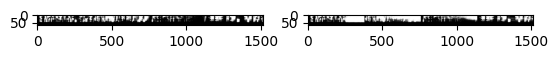

In [45]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

a = iter(trainloader)
images = a._next_data()


def imageshow_ax(image, ax):
    npimage = image.numpy()
    ax.imshow(np.transpose(npimage, (1, 2, 0)))

plt.figure(figsize=(15, 9))
fig, axs = plt.subplots(1, 2)

for image_number, ax in enumerate(axs.ravel()):
    imageshow_ax(torchvision.utils.make_grid(images[image_number][:4]), ax)

# Model

In [46]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, chnls_in=1, chnls_out=1):
        super(UNetGenerator, self).__init__()
        self.down_conv_layer_1 = DownConvBlock(chnls_in, 64, norm=False)
        self.down_conv_layer_2 = DownConvBlock(64, 128)
        self.down_conv_layer_3 = DownConvBlock(128, 256)
        self.down_conv_layer_4 = DownConvBlock(256, 256, dropout=0.5)
        self.down_conv_layer_5 = DownConvBlock(256, 256, dropout=0.5)
        self.down_conv_layer_6 = DownConvBlock(256, 256, dropout=0.5)

        self.up_conv_layer_1 = UpConvBlock(256, 256, kernel_size=(2,3), stride=2, padding=0, dropout=0.5)# 256+256 6 5 kernel_size=(2, 3), stride=2, padding=0
        self.up_conv_layer_2 = UpConvBlock(512, 256, kernel_size=(2,3), stride=2, padding=0, dropout=0.5) # 256+256 1 4
        self.up_conv_layer_3 = UpConvBlock(512, 256, kernel_size=(2,3), stride=2, padding=0, dropout=0.5) # 2 3
        self.up_conv_layer_4 = UpConvBlock(512, 128, dropout=0.5) # 3 2
        self.up_conv_layer_5 = UpConvBlock(256, 64) # 4 1
        self.up_conv_layer_6 = UpConvBlock(512, 128)
        self.up_conv_layer_7 = UpConvBlock(256, 64)
        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv_layer_1 = nn.Conv2d(128, chnls_out, 4, padding=1)
        self.activation = nn.Tanh()
    
    def forward(self, x):
        #print('x', x.shape)
        enc1 = self.down_conv_layer_1(x) # [4, 64, 32, 188]
        print('1', enc1.shape)
        enc2 = self.down_conv_layer_2(enc1) # [4, 128, 16, 94]
        print('2', enc2.shape)
        enc3 = self.down_conv_layer_3(enc2) # [4, 256, 8, 47]
        print('3', enc3.shape)
        enc4 = self.down_conv_layer_4(enc3) # [4, 256, 4, 23]
        print('4', enc4.shape)
        enc5 = self.down_conv_layer_5(enc4) # [4, 256, 2, 11]
        print('5', enc5.shape)
        enc6 = self.down_conv_layer_6(enc5) # [4, 256, 1, 5]
        #print('6', enc6.shape)
 
        dec1 = self.up_conv_layer_1(enc6, enc5)# enc6: 256 + enc5: 256 [4, 512, 2, 11]
        #print('d1', dec1.shape)
        dec2 = self.up_conv_layer_2(dec1, enc4)# enc4: 256 + dec1=enc5*2: [4, 512, 4, 23]
        #print('d2', dec2.shape)
        dec3 = self.up_conv_layer_3(dec2, enc3)# enc3: 256 + dec2=enc4*2: [4, 512, 8, 47]
        #print('d3', dec3.shape)
        dec4 = self.up_conv_layer_4(dec3, enc2)# enc2: 128 + dec3=enc3*2: [4, 256, 16, 94]
        #print('d4', dec4.shape)
        dec5 = self.up_conv_layer_5(dec4, enc1)# enc1: 64 + dec4=enc1*2: [4, 128, 32, 188]
        #print('d5', dec5.shape)
      
        final = self.upsample_layer(dec5)
        final = self.zero_pad(final)
        final = self.conv_layer_1(final)
        #print(final.shape)
        return final

class UpConvBlock(nn.Module):
    def __init__(self, ip_sz, op_sz, kernel_size=4, stride= 2, padding=1 ,dropout=0.0):
        super(UpConvBlock, self).__init__()
        self.layers = [
            nn.ConvTranspose2d(ip_sz, op_sz, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.InstanceNorm2d(op_sz),
            nn.ReLU(),
        ]
        if dropout:
            self.layers += [nn.Dropout(dropout)]
    def forward(self, x, enc_ip):
        x = nn.Sequential(*(self.layers))(x)
        #print('x', x.shape)
        #print('enc', enc_ip.shape)
        op = torch.cat((x, enc_ip), 1)
        return op


class DownConvBlock(nn.Module):
    def __init__(self, ip_sz, op_sz, kernel_size=4, norm=True, dropout=0.0):
        super(DownConvBlock, self).__init__()
        self.layers = [nn.Conv2d(ip_sz, op_sz, kernel_size, 2, 1)]
        if norm:
            self.layers.append(nn.InstanceNorm2d(op_sz))
        self.layers += [nn.LeakyReLU(0.2)]
        if dropout:
            self.layers += [nn.Dropout(dropout)]
    def forward(self, x):
        op = nn.Sequential(*(self.layers))(x)
        return op
    
model = UNetGenerator()

In [47]:
from tqdm import tqdm

def train(dataloader, model, epoch, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    for i, (clean, noisy) in enumerate(tqdm(dataloader)):
        clean = clean.to(device)
        noisy = noisy.to(device)
        
        optimizer.zero_grad()
        pred = model(noisy)
        curr_loss = loss_fn(pred, clean)
        curr_loss.backward()
        optimizer.step()

        total_loss += curr_loss
        if i % 1000 == 0:
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, total_loss / 200))
            total_loss = 0.0
            
def val(dataloader, model, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    print('-------------------------')
    with torch.no_grad():
        for i, (clean, noisy) in enumerate(tqdm(dataloader)):
            clean = clean.to(device)
            noisy = noisy.to(device)
        
            output = model(noisy)
            loss = loss_fn(output, clean)
            total_loss += loss
            if i % 100 == 0:
                print('[Valid Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, total_loss / 200))
                total_loss = 0.0
    
    

In [48]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
loss_fn = torch.nn.functional.mse_loss
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

model = UNetGenerator().cuda()

for epoch in range(config.epochs):
    train(trainloader, model, epoch, loss_fn, optimizer, device)
    val(validloader, model, epoch, loss_fn, device)

cuda


  0%|          | 0/16 [00:01<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
PATH = './working/model'
torch.save(model.state_dict(), PATH)